In [1]:
import sys
sys.path.append("..")

from configs.plot_config import apply_plot_settings
from configs.math_functions import F, gaussian, lognormal
from configs.parameters import *
from configs.filenames import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
from scipy.signal import find_peaks
from scipy.stats import lognorm
import scipy.interpolate as interp
from scipy.optimize import curve_fit
import os
import math

print(f"📢 Using parameters: C={C}, itr={itr}, sig={sig}")

📢 Using parameters: C=0.01, itr=20000, sig=0.1


In [2]:
apply_plot_settings()
output_dir = "../data/"

In [3]:
def format_sig(sig):
    rounded = round(sig, 2)
    return f"{rounded:.1f}" if rounded * 10 % 1 == 0 else f"{rounded:.2f}"

def get_zero_crossings(signal, time, period):
    signal = np.asarray(signal)
    time = np.asarray(time)
    crossings = np.where(np.diff(np.signbit(signal)))[0]
    
    zero_phases = []
    for idx in crossings:
        y0, y1 = signal[idx], signal[idx + 1]
        t0, t1 = time[idx], time[idx + 1]

        t_zero = t0 - y0 * (t1 - t0) / (y1 - y0)
        phase = (t_zero % period) / period
        zero_phases.append(phase)

    return zero_phases

In [4]:
sig_range = np.arange(0.01,1.01,0.01)

zero_crossings = {
    "direct":   {"EE": {}, "II": {}},
    "gaussian": {"EE": {}, "II": {}},
    "lognormal": {"EE": {}, "II": {}}
}

for sig in sig_range:
    sig = format_sig(sig)
    #print(sig)
    params = get_params_for_filename(param_keys, globals())

    filename = get_filename("discrete", "Interaction", **params)
    savefile_interaction = os.path.join(output_dir, filename)
    data = np.load(savefile_interaction, allow_pickle=True)
    tt_direct = data["tt"]
    H_odd_EE_direct = data["H_odd_EE"]
    ZE_direct = data["ZE"]
    tE_direct = data["tE"]
    H_odd_II_direct = data["H_odd_II"]
    ZI_direct = data["ZI"]
    tI_direct = data["tI"]
    T_direct = data["T"]
    
    filename = get_filename("gaussian", "Interaction", **params)
    savefile_interaction = os.path.join(output_dir, filename)
    data = np.load(savefile_interaction, allow_pickle=True)
    tt_gaussian = data["tt"]
    H_odd_EE_gaussian = data["H_odd_EE"]
    ZE_gaussian = data["ZE"]
    tE_gaussian = data["tE"]
    H_odd_II_gaussian = data["H_odd_II"]
    ZI_gaussian = data["ZI"]
    tI_gaussian = data["tI"]
    T_gaussian = data["T"]
    
    filename = get_filename("lognormal", "Interaction", **params)
    savefile_interaction = os.path.join(output_dir, filename)
    data = np.load(savefile_interaction, allow_pickle=True)
    tt_lognormal = data["tt"]
    H_odd_EE_lognormal = data["H_odd_EE"]
    ZE_lognormal = data["ZE"]
    tE_lognormal = data["tE"]
    H_odd_II_lognormal = data["H_odd_II"]
    ZI_lognormal = data["ZI"]
    tI_lognormal = data["tI"]
    T_lognormal = data["T"]

    ### Zero - Crossings
    ####################
    
    zero_crossings_direct_EE    = get_zero_crossings(H_odd_EE_direct,    tE_direct,    T_direct)
    zero_crossings_gaussian_EE  = get_zero_crossings(H_odd_EE_gaussian,  tE_gaussian,  T_gaussian) 
    zero_crossings_lognormal_EE = get_zero_crossings(H_odd_EE_lognormal, tE_lognormal, T_lognormal) 
    zero_crossings_direct_II    = get_zero_crossings(H_odd_II_direct,    tI_direct,    T_direct) 
    zero_crossings_gaussian_II  = get_zero_crossings(H_odd_II_gaussian,  tI_gaussian,  T_gaussian) 
    zero_crossings_lognormal_II = get_zero_crossings(H_odd_II_lognormal, tI_lognormal, T_lognormal) 

    zero_crossings["direct"]["EE"][str(sig)]    = zero_crossings_direct_EE
    zero_crossings["gaussian"]["EE"][str(sig)]  = zero_crossings_gaussian_EE
    zero_crossings["lognormal"]["EE"][str(sig)] = zero_crossings_lognormal_EE
    
    zero_crossings["direct"]["II"][str(sig)]    = zero_crossings_direct_II
    zero_crossings["gaussian"]["II"][str(sig)]  = zero_crossings_gaussian_II
    zero_crossings["lognormal"]["II"][str(sig)] = zero_crossings_lognormal_II

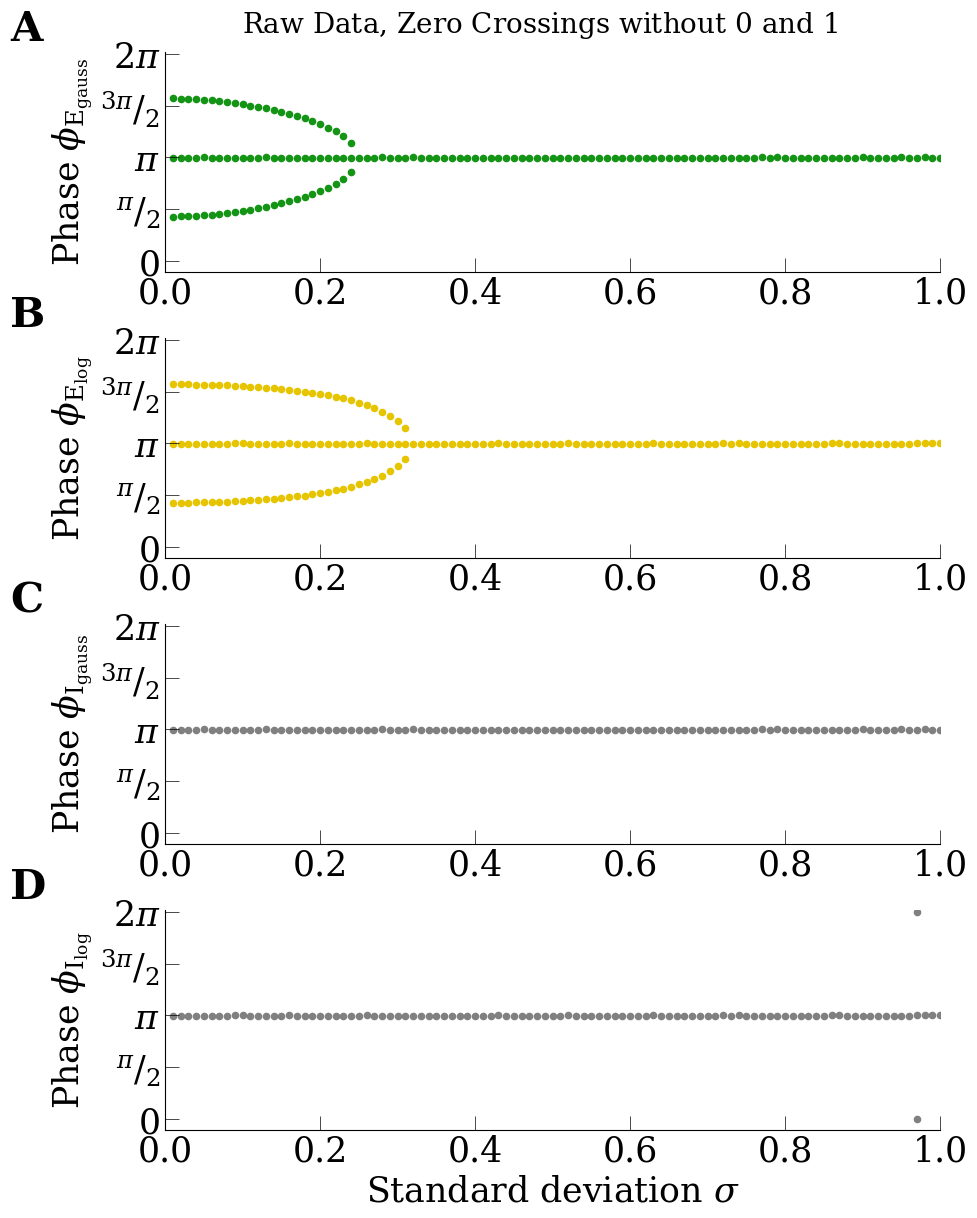

In [5]:
fig, axes = plt.subplots(4, 1, figsize=(10, 14))
plt.suptitle("Raw Data, Zero Crossings without $0$ and $1$", fontsize=20, y=0.91)
plt.subplots_adjust(hspace=0.3)

plots = [
    ("gaussian", "EE", "A"),
    ("lognormal", "EE", "B"),
    ("gaussian", "II", "C"),
    ("lognormal", "II", "D"),
]

for ax, (dist, pop, label) in zip(axes, plots):
    data = zero_crossings[dist][pop]

    for sig_str, phases in data.items():
        sig = float(sig_str)
        if label == "A":
            ax.set_ylabel(r"Phase $\phi_{\mathrm{E}_{\mathrm{gauss}}}$")
            ax.scatter([sig] * len(phases), phases, s=20, color='#149414')
        elif label == "B":
            ax.set_ylabel(r"Phase $\phi_{\mathrm{E}_{\mathrm{log}}}$")
            ax.scatter([sig] * len(phases), phases, s=20, color='#E6C500')
        elif label == "C":
            ax.set_ylabel(r"Phase $\phi_{\mathrm{I}_{\mathrm{gauss}}}$")
            ax.scatter([sig] * len(phases), phases, s=20, color='grey')
        elif label == "D":
            ax.set_ylabel(r"Phase $\phi_{\mathrm{I}_{\mathrm{log}}}$")
            ax.scatter([sig] * len(phases), phases, s=20, color='grey')

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05,1.01)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(('$0$', '$^{\pi}/_{2}$', '$\pi$', '$^{3\pi}/_{2}$', '$2\pi$'))
    ax.annotate(f"{label}", xy=(-0.2,1.05), xycoords='axes fraction',
                fontsize=30, weight="bold")

axes[-1].set_xlabel(r"Standard deviation $\sigma$")

plt.show()

## Make Bifurcation Diagram

In [6]:
def filter_phases_single(data_dict, center=0.49, delta=0.01):
    return {
        sig_str: [p for p in phases if abs(p - center) > delta]
        for sig_str, phases in data_dict.items()
    }

def f_quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def fit_parabola_turned(ax, x_data, y_data, color, linestyle='dashed', linewidth=3):
    """
    Fits a second-order polynomial: x = a*y^2 + b*y + c
    and plots the curve (a vertical parabola in the x-y space).
    """
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    if len(x_data) < 6:
        print("Not enough points for quadratic fit.")
        return

    popt, _ = curve_fit(f_quadratic, y_data, x_data)

    y_fit = np.linspace(0, 1, 300)
    x_fit = f_quadratic(y_fit, *popt)

    ax.plot(x_fit, y_fit, color=color, linestyle=linestyle, linewidth=linewidth)


/tmp/ipykernel_1520507/1414986582.py:64: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x_lower, y_lower, '.', marker="d", markersize=10,
/tmp/ipykernel_1520507/1414986582.py:67: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x_upper, y_upper, '.', marker="d", markersize=10,
/tmp/ipykernel_1520507/1414986582.py:112: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x_lower, y_lower, '.', marker="d", markersize=10,
/tmp/ipykernel_1520507/1414986582.py:115: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(x_upper,

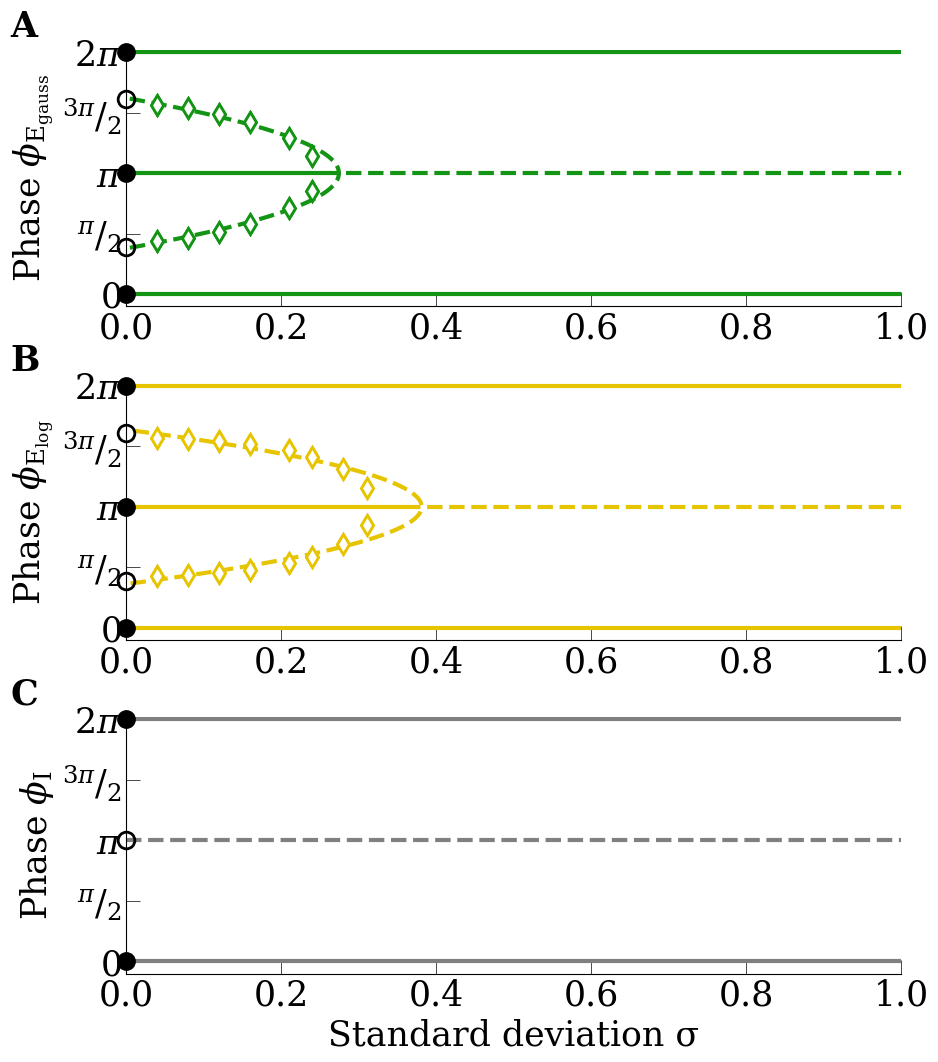

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

plt.subplots_adjust(hspace=0.3)

plots = [
    ("gaussian", "EE", "A"),
    ("lognormal", "EE", "B"),
    ("gaussian", "II", "C"),
]

for ax, (dist, pop, label) in zip(axes, plots):
    data = filter_phases_single(zero_crossings[dist][pop])

    for sig_str, phases in data.items():
        sig = float(sig_str)
        #ax.scatter([sig] * len(phases), phases, s=20, alpha=0.8)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05,1.01)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(('$0$', '$^{\pi}/_{2}$', '$\pi$', '$^{3\pi}/_{2}$', '$2\pi$'))

    if label == "A":
        ax.set_ylabel(r"Phase $\phi_{\mathrm{E}_{\mathrm{gauss}}}$")
        ax.hlines(1,0,1, color = '#149414', linewidth = 3)
        ax.hlines(0.5,0,0.274, color = '#149414', linewidth = 3)
        ax.hlines(0.5,0.284,1, color = '#149414', linewidth = 3, linestyle = 'dashed')
        ax.hlines(0,0,1, color = '#149414', linewidth = 3)

        x_direct_stable = [0,0,0]
        y_direct_stable = [0.5,0,1.0]
        x_direct_unstable = [0,0]
        y_direct_unstable = [0.805,0.195]
        ax.plot(x_direct_stable, y_direct_stable, '.', color = 'black', markersize = 25, clip_on=False, zorder=10)[0]
        ax.plot(x_direct_unstable, y_direct_unstable, 'o', color = 'black', markersize = 12,markeredgewidth=2,markeredgecolor='black',markerfacecolor='None', clip_on=False, zorder=10)[0]

        sigmas = []
        phases = []
        for sig_str, phase_list in data.items():
            sig = float(sig_str)
            for p in phase_list:
                sigmas.append(sig)
                phases.append(p)
        fit_parabola_turned(ax, sigmas, phases, color='#149414')

        x_target = [0.04, 0.08, 0.12, 0.16, 0.21, 0.24, 0.24, 0.21, 0.16, 0.12, 0.08, 0.04]
        
        x_lower, y_lower = [], []
        x_upper, y_upper = [], []
        
        for x in x_target:
            sig_str = f"{x:.2f}"
            phase_list = data.get(sig_str, [])
            if len(phase_list) >= 2:
                lower = min(phase_list)
                upper = max(phase_list)
                x_lower.append(x)
                y_lower.append(lower)
                x_upper.append(x)
                y_upper.append(upper)
            elif len(phase_list) == 1:
                pass

        ax.plot(x_lower, y_lower, '.', marker="d", markersize=10,
                markeredgewidth=2, markeredgecolor='#149414',
                markerfacecolor='white', zorder=10)
        ax.plot(x_upper, y_upper, '.', marker="d", markersize=10,
                markeredgewidth=2, markeredgecolor='#149414',
                markerfacecolor='white', zorder=10)

    elif label == "B":
        ax.set_ylabel(r"Phase $\phi_{\mathrm{E}_{\mathrm{log}}}$")
        ax.hlines(1,0,1, color = '#E6C500', linewidth = 3)
        ax.hlines(0.5,0,0.36, color = '#E6C500', linewidth = 3)
        ax.hlines(0.5,0.36,1, color = '#E6C500', linewidth = 3, linestyle = 'dashed')
        ax.hlines(0,0,1, color = '#E6C500', linewidth = 3)

        x_direct_stable = [0,0,0]
        y_direct_stable = [0.5,0,1.0]
        x_direct_unstable = [0,0]
        y_direct_unstable = [0.805,0.195]
        ax.plot(x_direct_stable, y_direct_stable, '.', color = 'black', markersize = 25, clip_on=False, zorder=10)[0]
        ax.plot(x_direct_unstable, y_direct_unstable, 'o', color = 'black', markersize = 12,markeredgewidth=2,markeredgecolor='black',markerfacecolor='None', clip_on=False, zorder=10)[0]

        sigmas = []
        phases = []
        for sig_str, phase_list in data.items():
            sig = float(sig_str)
            for p in phase_list:
                sigmas.append(sig)
                phases.append(p)
        fit_parabola_turned(ax, sigmas, phases, color='#E6C500')

        x_target = [0.04, 0.08, 0.12, 0.16, 0.21, 0.24, 0.28, 0.31, 0.31, 0.28, 0.24, 0.21, 0.16, 0.12, 0.08, 0.04]
        
        x_lower, y_lower = [], []
        x_upper, y_upper = [], []
        
        for x in x_target:
            sig_str = f"{x:.2f}"
            phase_list = data.get(sig_str, [])
            if len(phase_list) >= 2:
                lower = min(phase_list)
                upper = max(phase_list)
                x_lower.append(x)
                y_lower.append(lower)
                x_upper.append(x)
                y_upper.append(upper)
            elif len(phase_list) == 1:
                pass

        ax.plot(x_lower, y_lower, '.', marker="d", markersize=10,
                markeredgewidth=2, markeredgecolor='#E6C500',
                markerfacecolor='white', zorder=10)
        ax.plot(x_upper, y_upper, '.', marker="d", markersize=10,
                markeredgewidth=2, markeredgecolor='#E6C500',
                markerfacecolor='white', zorder=10)

    elif label == "C":
        ax.set_ylabel(r"Phase $\phi_{\mathrm{I}}$")
        ax.hlines(1,0,1, color = 'grey', linewidth = 3)
        ax.hlines(0.5,0,1, color = 'grey', linewidth = 3, linestyle = 'dashed')
        ax.hlines(0,0,1, color = 'grey', linewidth = 3)
        
        x_direct_stable = [0,0]
        y_direct_stable = [0,1.0]
        x_direct_unstable = [0]
        y_direct_unstable = [0.5]
        ax.plot(x_direct_stable, y_direct_stable, '.', color = 'black', markersize = 25, clip_on=False)[0]
        ax.plot(x_direct_unstable, y_direct_unstable,'o', color = 'black', markersize = 12,markeredgewidth=2,markeredgecolor='black',markerfacecolor='None', clip_on=False)[0]


    ax.annotate(f"{label}", xy=(-0.15,1.05), xycoords='axes fraction',
                fontsize=25, weight="bold")

axes[-1].set_xlabel("Standard deviation σ")

plt.savefig("../figures/fig5.pdf", bbox_inches="tight")
plt.show()